# Example workflow for loading and linearizing position data

### SECTIONS
**General Background**  

**1. Loading and plotting position data**  
**2. Getting position data conversion factors**  
**3. Making coords**  
**4. Getting choice points manually**  
**5. Linearizing position data**  

**OPTIONAL: Understanding the linearization pipeline**  
&nbsp;&nbsp;&nbsp;&nbsp;**6.1. Standardizing coords**  
&nbsp;&nbsp;&nbsp;&nbsp;**6.2. Transformation and preservation of position information**

### Before you begin...

Remember, this is a visual reference guide to the example workflow MATLAB code and is not intended to be run as is. Some of the code you will see here is particular to jupyter notebook or for the purpose of better visualization.  For example, you'll see `%plot -s` in front of a figure call from time to time. This is a magic function used to set the size of the figure in jupyter notebook, *not in matlab*! For a complete tutorial, please follow along and step through the example code in `Loading_and_Linearizing_Position.m`

### GENERAL BACKGROUND

Position data is collected by an overhead camera and position tracking algorithm as it views the bright, point source of light emitted by the headstage LEDs. This position data is saved in the Neuralynx .nvt file.

In the vandermeerlab codebase, position data is loaded using the function LoadPos(), and the x and y coordinate positions are accessed using the function getd().

In analyses involving the use of repeated trajectories, it is necessary to store the idealized path a rat would take along the track. These idealized paths, or coords, are saved for later use in scripts that order place cells based on their field positions on the track.

This workflow takes you through position data loading and linearizing using the example session R050-2014-04-02 recorded in RR1 at UW. R050's maze is T-shaped and has one choice point. The end of the left arm has a food reward and the end of the right arm has a water reward.

First, we add the codebase functions to our path and set the current directory to the session we want to work with:

In [1]:
warning('off','all') %only since its annoying otherwise

cd('/Users/youkitanaka/Documents/Github/vandermeerlab/code-matlab/shared'); % user path for codebase
p = genpath(pwd);
addpath(p);

cd('/Users/youkitanaka/Documents/data/R050/R050-2014-04-02') % user session directory

### 1. Loading and plotting position data

Using an empty config loads the position data in the default units of pixels (see output):

In [2]:
cfg = [];
pos = LoadPos(cfg)

LoadPos.m: 100.00% of samples tracked.

pos = 

     type: 'tsd'
    units: 'px'
     tvec: [1x133233 double]
     data: [2x133233 double]
    label: {'x'  'y'}
      cfg: [1x1 struct]



We can simply call `plot()` on the tsd object but we can also specify the data we want to plot using `getd()` which extracts the dimensions of the tsd that correspond to the input labels (in this case, 'x' and 'y'):

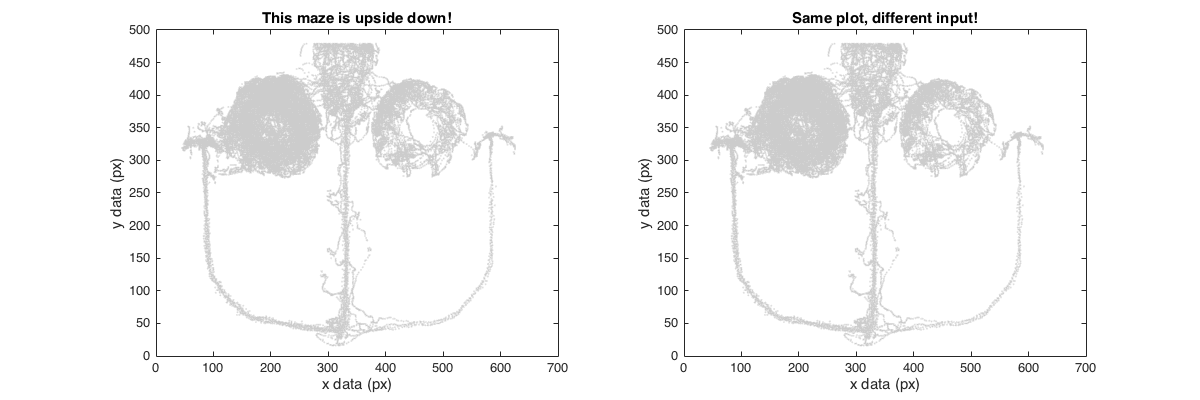

In [3]:
%plot -s 1200,400
figure;
subplot(121);
plot(pos,'.','MarkerSize',4,'Color',[0.8 0.8 0.8]) % call plot() directly on tsd
xlabel('x data (px)'); ylabel('y data (px)'); title('This maze is upside down!')

subplot(122);
plot(getd(pos,'x'),getd(pos,'y'),'.','MarkerSize',4,'Color',[0.8 0.8 0.8]); % use getd() to specify which tsd data
xlabel('x data (px)'); ylabel('y data (px)'); title('Same plot, different input!')

Either way, you get the same plot!

In reality, R050's maze was oriented such that the top of the T points up. Notice here that the T-maze is actually upside down! This is because the camera mirrors the data in the Y axis.

We can set certain axis properties so that the position data is plotted in the orientation we want to see it, but at the same time preserve the real data points and their relationships to one another:

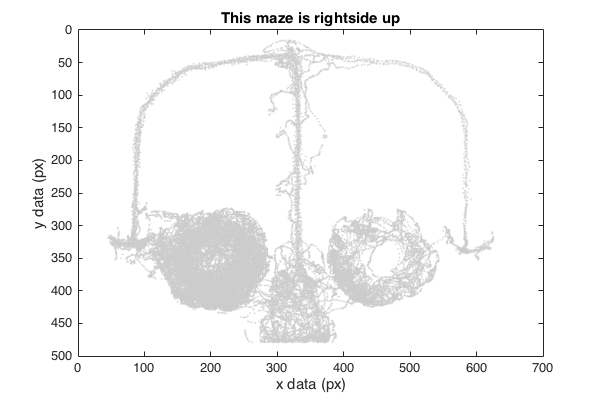

In [4]:
%plot -s 600,400
figure; plot(pos,'.','MarkerSize',4,'Color',[0.8 0.8 0.8]); 
xlabel('x data (px)'); ylabel('y data (px)');
set(gca,'YDir','reverse') % this flips the Y axis
title('This maze is rightside up')

You can also rotate the plot in any number of ways. For example, let us flip the maze in the Y-axis and rotate it by 270˚:

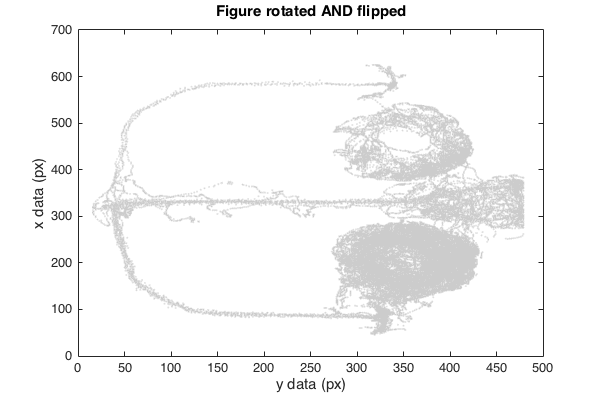

In [5]:
figure; plot(pos,'.','MarkerSize',4,'Color',[0.8 0.8 0.8]);
xlabel('x data (px)'); ylabel('y data (px)');
set(gca,'YDir','reverse') % this flips the Y axis
view(270,90); % the number 270 rotates the plot 270 degrees CLOCKWISE
title('Figure rotated AND flipped')

Make sure you understand the above plotting examples because they are important for the next steps -- making coords properly and getting the outer boundaries of your track!

### 2. Getting position data conversion factors

So far, we've been working with position data in pixels but you might want to load position data in centimeters instead. To do this, you need the real dimensions of your track in cm.

These dimensions must be as if the track fits perfectly into a box that has the same orientation as the camera's field of view. That is, the length and width should be measured parallel to edges of the video feed (see MATLAB code for ASCII schematic).

Furthermore, the dimesions should be measured according to the trajectory the rat would have followed, ie: don't measure from one outer edge to the opposite outer edge, because the rat doesn't walk along the edge -- he walks along the center (unless he's an acrobat or weird).

These dimensions should be saved in your ExpKeys as: `ExpKeys.realTrackDims = [xWidth yWidth];`  

For the time being, let us specify these values:

In [6]:
realTrackDims = [185 167];

Now that we have the track dimensions, we can use `PosCon()` to get the conversion factor for our position tsd. `PosCon()` will reorient your maze if you pass in certain varargins. Read the help documentation on `PosCon()` for more intructions. If you are using data recorded in RR1 of UWaterloo you should flip the Y axis unless `LoadPos()` is changed to load the Y data differently. 

Try using `PosCon()` yourself and see how the results differ based on where you click! For the purpose of the tutorial, we'll specify the conversion factor from the ExpKeys we have saved:

In [7]:
convFact = [2.6853 2.6169]
%convFact = PosCon(pos,realTrackDims,'YDir','reverse')


convFact =

    2.6853    2.6169



You should save convFact in ExpKeys as: `ExpKeys.convFact = [xConvFact yConvFact];`

Now that we have the conversion factor for pixels to cm, we can also plot the position data in cm by using the `.convFact` flag in our config options:

LoadPos.m: 100.00% of samples tracked.

pos_cm = 

     type: 'tsd'
    units: 'cm'
     tvec: [1x133233 double]
     data: [2x133233 double]
    label: {'x'  'y'}
      cfg: [1x1 struct]



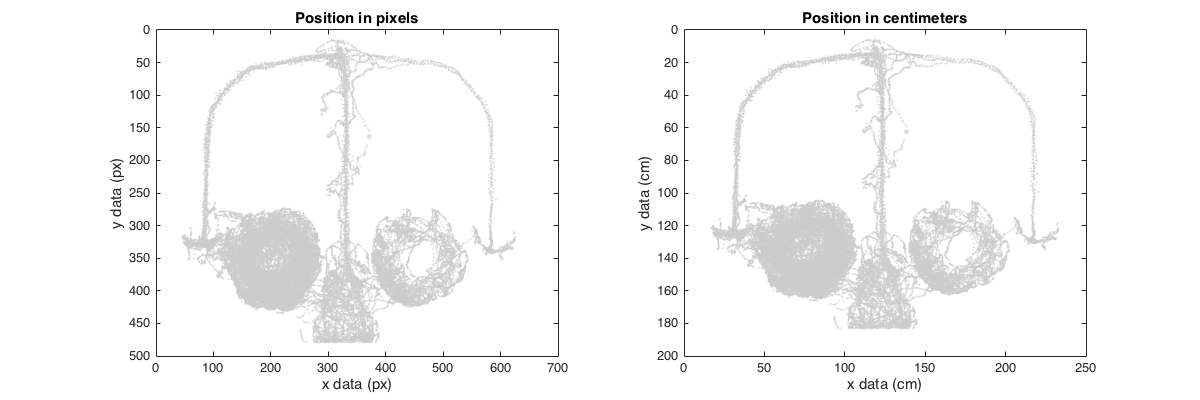

In [8]:
%plot -s 1200,400
cfg = []; cfg.convFact = convFact;
pos_cm = LoadPos(cfg)

subplot(121);
plot(pos,'.','MarkerSize',4,'Color',[0.8 0.8 0.8]) % position loaded earlier without convFact input
xlabel('x data (px)'); ylabel('y data (px)'); title('Position in pixels');
set(gca,'YDir','reverse') % this flips the Y axis

subplot(122);
plot(pos_cm,'.','MarkerSize',4,'Color',[0.8 0.8 0.8]); % position loaded using convFact input
xlabel('x data (cm)'); ylabel('y data (cm)'); title('Position in centimeters');
set(gca,'YDir','reverse') % this flips the Y axis


Notice how the units field in the tsd changed from 'px' to 'cm'. This means the data was successfully converted.

### 3. Making coords

As mentioned earlier, in analyzing trajectories it can be useful to be able to store idealized paths the rat might take in a two dimensional environment. These idealized paths can be stored as "coords" which are a set of coordinates that define a user drawn trajectory. We use the function `MakeCoord()` to do this. Read its internal documentation for more information. If you follow along with the MATLAB script, running the function `MakeCoord()` will open a figure and prompt you to draw a trajectory with clicks. 

`MakeCoord()` takes varargins that can reorient your maze as you prefer to see it. If the data was recorded in RR1 in 
UWaterloo you should always flip the Y axis unless `LoadPos()` is changed to do load the Y data differently.

In [9]:
coordL = MakeCoord(pos,'titl','Draw left trajectory, press enter when done','YDir','reverse') 
coordR = MakeCoord(pos,'titl','Draw right trajectory, press enter when done','YDir','reverse')


coordL = 

           coord: [2x851 double]
           units: 'px'
        run_dist: []
         nPoints: 851
       pointDist: 1.0003
    standardized: 0


coordR = 

           coord: [2x866 double]
           units: 'px'
        run_dist: []
         nPoints: 866
       pointDist: 1.0018
    standardized: 0



Depending on how you draw your trajectory, the number of points `.nPoints` (the length of the coord vector) can differ. Try running it multiple times with varying clicks! You should get something like this:

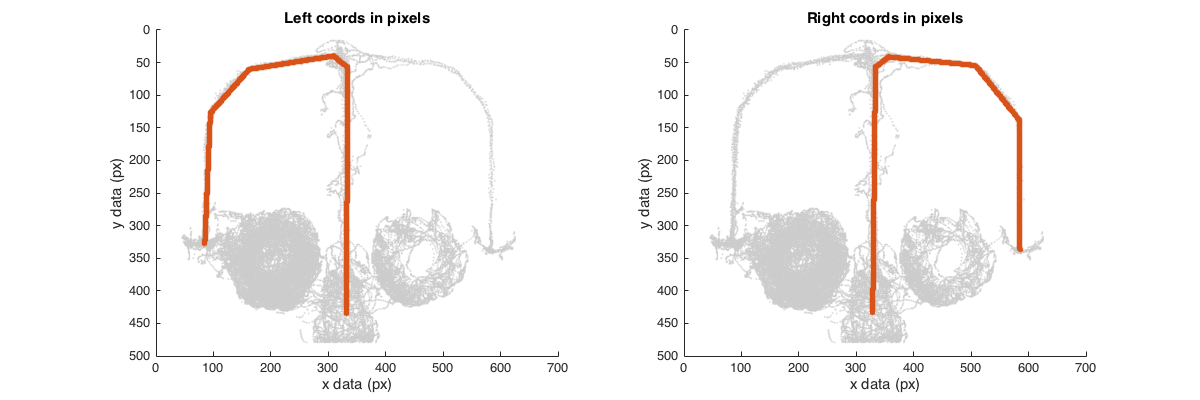

In [10]:
%plot -s 1200,400
figure;
subplot(121)
hold on;
plot(pos,'.','MarkerSize',4,'Color',[0.8 0.8 0.8])
plot(coordL.coord(1,:),coordL.coord(2,:),'o','MarkerSize',3);
xlabel('x data (px)'); ylabel('y data (px)'); title('Left coords in pixels');
set(gca,'YDir','reverse') % this flips the Y axis

subplot(122)
hold on;
plot(pos,'.','MarkerSize',4,'Color',[0.8 0.8 0.8])
plot(coordR.coord(1,:),coordR.coord(2,:),'o','MarkerSize',3);
xlabel('x data (px)'); ylabel('y data (px)'); title('Right coords in pixels');
set(gca,'YDir','reverse') % this flips the Y axis

These coords should be converted to units of cm using the convFact you already collected above:

In [11]:
coordL_cm = coordL; % copy coordL under a new variable name, and apply some changes:
coordL_cm.coord(1,:) = coordL_cm.coord(1,:)./convFact(1); % apply x conversion
coordL_cm.coord(2,:) = coordL_cm.coord(2,:)./convFact(2); % apply y conversion
coordL_cm.unts = 'cm';

coordR_cm = coordR; % as above, for R instead
coordR_cm.coord(1,:) = coordR_cm.coord(1,:)./convFact(1); % apply x conversion
coordR_cm.coord(2,:) = coordR_cm.coord(2,:)./convFact(2); % apply y conversion
coordR_cm.units = 'cm';

coords = struct('coordL',coordL,'coordL_cm',coordL_cm,'coordR',coordR,'coordR_cm',coordR_cm)
clear coordL coordL_cm coordR coordR_cm


coords = 

       coordL: [1x1 struct]
    coordL_cm: [1x1 struct]
       coordR: [1x1 struct]
    coordR_cm: [1x1 struct]



Alternatively, you can always load the position data in centimeters to generate coords in centimeters. `MakeCoord()` will inherit whatever units our input position tsd is in!

Notice that we put all the coord data in a single struct for tighter packing in the base workspace (when loading variables later). Now we have a single coord struct containing coords in both pixels and centimeters.

### 4. Getting choice points manually

If your maze has any choice points, it's probably a good idea to get the coordinates of those choice points. Here's how you can do this using a script:


coords = 

       coordL: [1x1 struct]
    coordL_cm: [1x1 struct]
       coordR: [1x1 struct]
    coordR_cm: [1x1 struct]
          chp: [2x1 double]
       chp_cm: [2x1 double]



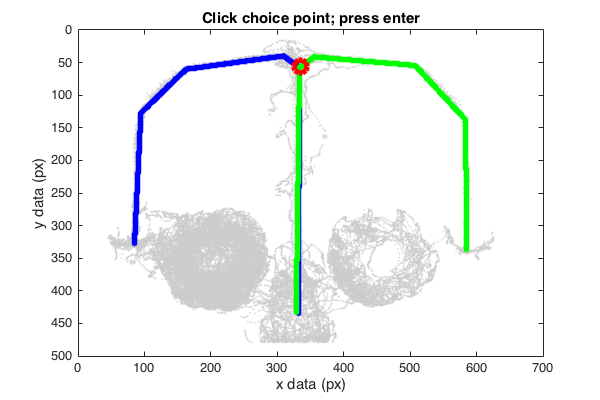

In [12]:
%plot -s 600,400
figure; 
plot(pos,'.','Color',[0.8 0.8 0.8],'MarkerSize',4); set(gca,'YDir','reverse'); hold on;
plot(coords.coordL.coord(1,:),coords.coordL.coord(2,:),'ob','MarkerSize',3); 
plot(coords.coordR.coord(1,:),coords.coordR.coord(2,:),'og','MarkerSize',3); 
xlabel('x data (px)'); ylabel('y data (px)'); title('Click choice point; press enter');

% get user input:
[x,y] = ginput;

plot(x,y,'or','MarkerSize',10,'LineWidth',4); %pause(1); close

% convert choice point units

chp = [x; y];
chp_cm = [x/convFact(1); y/convFact(2)];

% add to coord
coords.chp = chp;
coords.chp_cm = chp_cm

You can see above the two coords plotted on top of all of the position data (blue, left; green, right) and the choice point in red. 

Notice that we also added the choice point data to our coords struct we made earlier. All of the trajectory information is now stored in one place. You can now save these in metadata as: `metadata.coords = coords`

### 5. Linearizing position data

You can think of linearizing as "pushing the position data onto the nearest point along the coord trajectory". For more information, see the `LinearizePos()` documentation. Let's take a small portion of the position data and linearize it.

Normally you would have a separate script that defines the trial start and stop times; for the sake of this example, here are the trial intervals for all right trials that R050 did for the example session:

In [13]:
tstart = [5891.562065; 6717.689002; 7169.673936; 7634.938343; 7845.917153];
tend = [5983.521056; 6726.830367; 7187.524988; 7644.281508; 7856.827519];
trial_iv_R = iv(tstart,tend)
clear tstart tend


trial_iv_R = 

      type: 'iv'
    tstart: [5x1 double]
      tend: [5x1 double]
       usr: []
       cfg: [1x1 struct]



Now, restrict the position data (in cm) to the right trials only:


posR = 

     type: 'tsd'
    units: 'cm'
     tvec: [1x3720 double]
     data: [2x3720 double]
    label: {'x'  'y'}
      cfg: [1x1 struct]



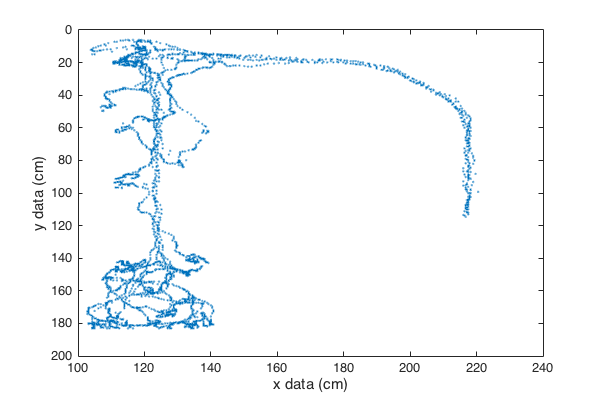

In [14]:
%plot -s 600,400
posR = restrict(pos_cm,trial_iv_R)

% You can plot the output to see what this looks like:
figure; plot(posR,'.'); set(gca,'YDir','reverse');
xlabel('x data (cm)'); ylabel('y data (cm)');

Now that we have some right trial position data, let's try to linearize that data:

In [15]:
linpos = LinearizePos([],posR,coords.coordR)

LinearizePos: linearizing data...
LinearizePos: Inputs do not have same units. Converting variables to match pos_tsd...
LinearizePos: WARNING, input coords are not standardized.

linpos = 

     type: 'tsd'
    units: 'idx'
     tvec: [1x3720 double]
     data: [1x3720 double]
    label: {'z'}
      cfg: [1x1 struct]



Success! But we're not done yet... Notice that `LineraizePos()` was successfully run, but it displayed a few warning messages...

"`LinearizePos: Inputs do not have same units.`" This message gets displayed when the input coord and tsd don't have the same units. If available, the function will convert the units of the coords using the convFact stored in the ExpKeys.

Let's try passing coords with the same units as our position tsd:

In [16]:
linpos = LinearizePos([],posR,coords.coordR_cm)

LinearizePos: linearizing data...
LinearizePos: WARNING, input coords are not standardized.

linpos = 

     type: 'tsd'
    units: 'idx'
     tvec: [1x3720 double]
     data: [1x3720 double]
    label: {'z'}
      cfg: [1x1 struct]



Now that warning is gone! What about "`LinearizePos: WARNING, input coords are not standardized`" -- as written, this means that we are dealing with "raw" coords. This won't necessarily matter depending on the analyses so for now, let's keep that in the back of our minds...

Finally, let's compare our 2D vs linearized position data for a single trial: 

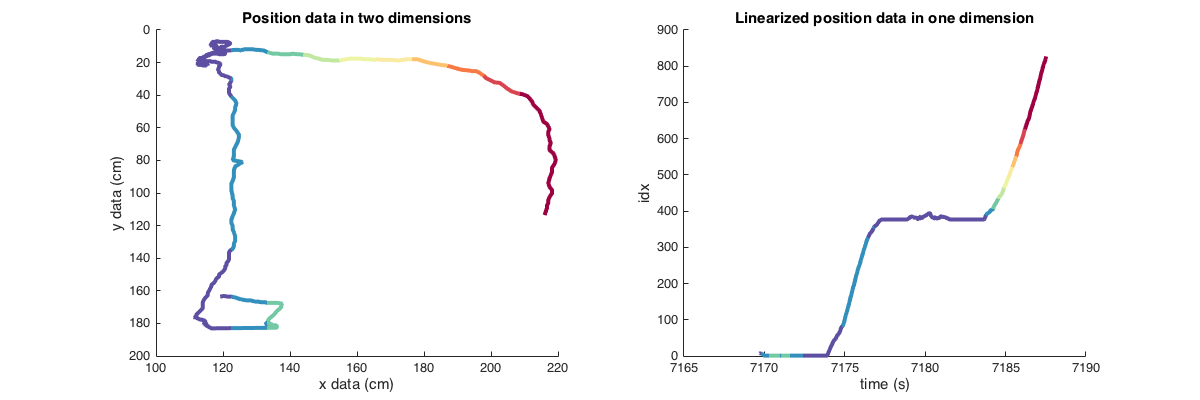

In [17]:
%plot -s 1200,400

pos2D = restrict(posR,trial_iv_R.tstart(3),trial_iv_R.tend(3));
pos1D = restrict(linpos,trial_iv_R.tstart(3),trial_iv_R.tend(3));

figure;
subplot(121)
x = getd(pos2D,'x'); 
y = getd(pos2D,'y'); 
z = zeros(size(x)); 
col = x;
surface([x;x],[y;y],[z;z],[col;col],'facecol','no','edgecol','interp','linew',3);
set(gca,'YDir','reverse');
xlabel('x data (cm)'); ylabel('y data (cm)'); title('Position data in two dimensions');

subplot(122)
x = pos1D.tvec; 
y = pos1D.data;
surface([x;x],[y;y],[z;z],[col;col],'facecol','no','edgecol','interp','linew',3);
xlabel('time (s)'); ylabel('idx'); title('Linearized position data in one dimension');

colormap(linspecer(10))

If you're confused about the plotting code, don't worry! This is just a "trick" to be able use the same color map along the trajctory. The colors match across plots meaning for example, that at roughly 7185 seconds, the rat is at the light green point in both data. In the 2D data, you can tell he's just past the choice point. In the linearized data, you can tell he's about halfway in the trajectory.

#### This completes the basic part of the example workflow!   

### OPTIONAL: Understanding the linearization pipeline

NOTE: The following optional section does not have an exact counterpart in the MATLAB example workflow. The code below is mainly for illustrating the how to think about linearization.

Now that you have a basic grasp of the overall workflow, let's take a look at some specifics. Earlier, we set aside the issue of standardization. What is coord standardization? 

### 6.1 Standardizing Coords

In order to understand what standardization does, let's first take a look at those coords we made earlier.

In [18]:
coords.coordR


ans = 

           coord: [2x866 double]
           units: 'px'
        run_dist: []
         nPoints: 866
       pointDist: 1.0018
    standardized: 0



Notice that the `.standardized` flag is set to 0 and `.run_dist` is empty! The output of `MakeCoord()` will always have these parameters and the coord will have the maximum number of points spaced out by ~1 unit of the input position tsd. So in this case, our input tsd had units in 'px' so our trajectory is [nPoints] points spaced [pointDist] px apart. You can confirm this default behavior by running `MakeCoord()` multiple times with same or different drawn trajectories. 

Now, suppose you're running rats on the same maze across multiple days or sessions. In order to run analyses across these data, we want a way to standardize the trajectory across trials and sessions. The function `StandardizeCord()` does this job.

`StandardizeCoord()` takes a raw coord file and returns a standardized coord. You'll notice the function requires a `run_dist` argument. This is the true path length of the user defined trajectory measured by the experimenter (i.e., what is the distance the rat actually ran?). 

In the case of the T-maze data, this distance is the path length from the start (at the bottom) to the reward location (ends of arms). This value should be stored in your ExpKeys:

In [19]:
LoadExpKeys
run_dist = ExpKeys.pathlength


run_dist =

   334



Now that we have all our necessary ingredients, we can run `StandardizeCoord()`:

In [20]:
coord_std = StandardizeCoord([],coords.coordR_cm,run_dist)

StandardizeCoord: standardizing coord...

coord_std = 

           coord: [2x100 double]
           units: 'cm'
        run_dist: 334
         nPoints: 100
       pointDist: 3.3400
    standardized: 1



You'll notice several values of the coord fields have changed. First, the length of the coord data (nPoints) has changed. By default, `StandardizeCoord()` will attempt to use 100 points. This means the function interpolates the coord data such that there are exactly 100 points in the trajectory.

Alternatively, we can specify how many points we want or even how we want to bin this trajectory. See `StandardizeCoord()` internal documentation for details.

In [21]:
coord_std = StandardizeCoord([],coords.coordR_cm,run_dist,'pointDist',3)

StandardizeCoord: standardizing coord...
StandardizeCoord: input pointDist factors incorrectly. Approximating value...

coord_std = 

           coord: [2x111 double]
           units: 'cm'
        run_dist: 334
         nPoints: 111
       pointDist: 3.0090
    standardized: 1



Here, we specified the argument `('pointDist',3)`. This tells the function to interpolate the coord data such that the distance between all the points in coord are 3cm apart (or as close to your argument as possible). Since the length of the trajectory is 334cm, this means there can be a maximum of 111 points spaced out by 3.009cm. 

NOTE: the value of `coord_std.pointDist` (standardized coord) is in units of run_dist while the value of `coordR.pointDist` (raw coord) is in units of `pos`

### 6.2 Transformation and preservation of position information

Now that we have our standardized coord, let's linearize our position data again:

In [22]:
linpos_std = LinearizePos([],posR,coord_std)

LinearizePos: linearizing data...

linpos_std = 

     type: 'tsd'
    units: 'idx'
     tvec: [1x3720 double]
     data: [1x3720 double]
    label: {'z'}
      cfg: [1x1 struct]



At first glance the output looks exactly the same as before, but let's take a closer look look at our linearized data by restricting to a specific trial:

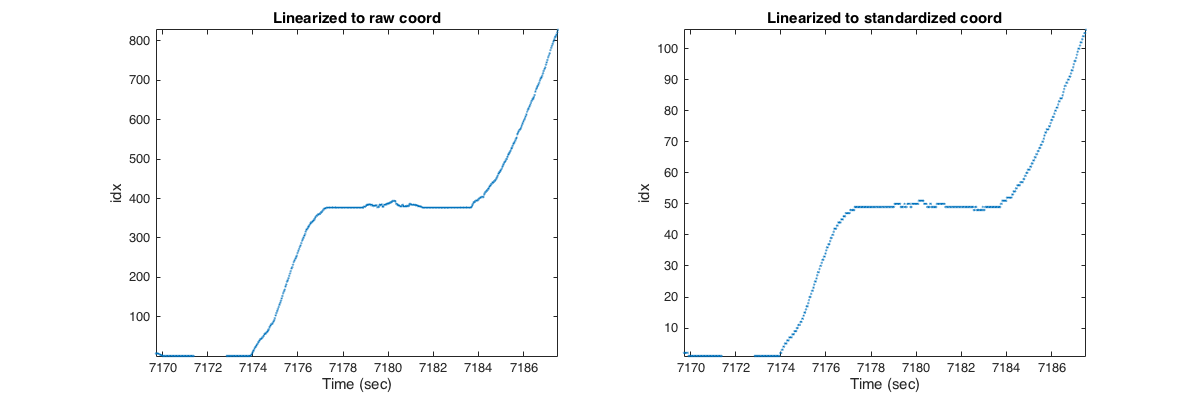

In [23]:
%plot -s 1200,400

lp1 = restrict(linpos,trial_iv_R.tstart(3),trial_iv_R.tend(3));
lp2 = restrict(linpos_std,trial_iv_R.tstart(3),trial_iv_R.tend(3));

figure;
hold on;
subplot(121); plot(lp1,'.'); axis tight; title('Linearized to raw coord')
xlabel('Time (sec)'); ylabel('idx');
subplot(122); plot(lp2,'.'); axis tight; title('Linearized to standardized coord')
xlabel('Time (sec)'); ylabel('idx');

Now we can see that having less coord points (a smaller `.nPoints`) "bins" the data. Let's take a closer look... ENHANCE!

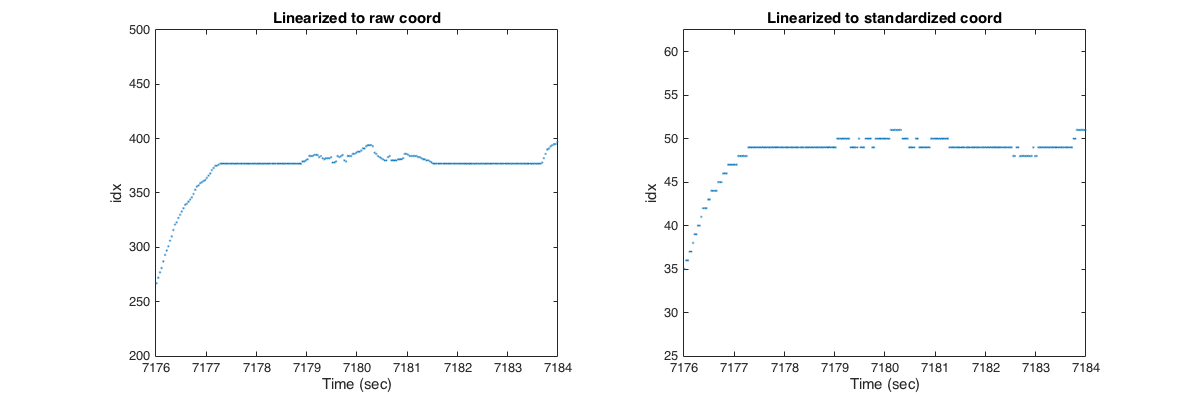

In [24]:
%plot -s 1200,400
figure;
hold on;
subplot(121); plot(lp1,'.'); axis tight; title('Linearized to raw coord')
xlabel('Time (sec)'); ylabel('idx'); 
axis([7176 7184,200,500])
subplot(122); plot(lp2,'.'); axis tight; title('Linearized to standardized coord')
xlabel('Time (sec)'); ylabel('idx');
axis([7176 7184,25,62.5])

Depending on what you intend to do with the data next, it might be easier to deal with the data binned more or less. When generating tuning curves for example, you will typically bin your tuning variable (position in this case). Using `LinearizePos()` with `StandardizeCoord()` builds this step into the pipeline.

On top of "binning", another important consideration in the pipeline is what unit information is perserved in the process. You'll notice that the output of `LinearizePos()` is in `'idx'` units. This refers to the fact that the `z` value of the linearized position is actually the index of the coord. In other words, "how far along this template trajectory is each position time stamp?" But suppose you want to know not just the index of the coord but also the distance of the linearized position. 

You can set the `.outputType` flag as `dist` in the config option for `LinearizePos()` to return distance along the coord trajectory:

LinearizePos: linearizing data...

linpos_cm = 

     type: 'tsd'
    units: 'dist'
     tvec: [1x3720 double]
     data: [1x3720 double]
    label: {'z'}
      cfg: [1x1 struct]



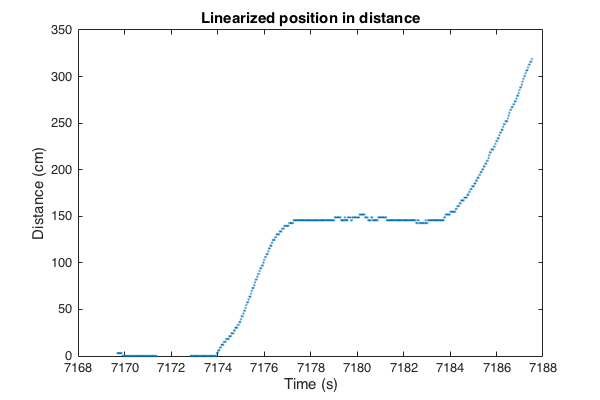

In [25]:
%plot -s 600,400
cfg = []; cfg.outputType = 'dist';
linpos_cm = LinearizePos(cfg,posR,coord_std)
lp_cm = restrict(linpos_cm,trial_iv_R.tstart(3),trial_iv_R.tend(3));
plot(lp_cm,'.')
xlabel('Time (s)'); ylabel('Distance (cm)'); title('Linearized position in distance');

Now if you look at the Y-axis, the points correspond to an interpolated distance along the trajectory.

But this still leaves the question what the warping from 2D to 1D does to the accuracy of the position information. You can use a the `.debugMode` flag in `LinearizePos()` to output the distance from each point in the position data to the coord data:

LinearizePos: linearizing data...

linpos_db = 

     type: 'tsd'
    units: 'idx'
     tvec: [1x3720 double]
     data: [2x3720 double]
    label: {'z'  'z_dist'}
      cfg: [1x1 struct]



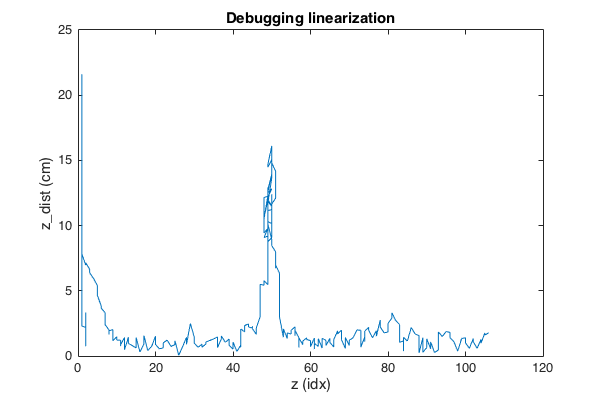

In [26]:
%plot -s 600,400
cfg = []; cfg.debugMode = 1;
linpos_db = LinearizePos(cfg,posR,coord_std)
lp_db = restrict(linpos_db,trial_iv_R.tstart(3),trial_iv_R.tend(3));
plot(lp_db)
xlabel('z (idx)'); ylabel('z\_dist (cm)'); title('Debugging linearization');

It might seem a little unintuitive at first, but the way to think of this plot is that larger deflections in the Y-axis mean larger differences in the coord data vs position data. 

Let's put all of it together and examine this plot side-by-side with the 2D and linearization plots below:

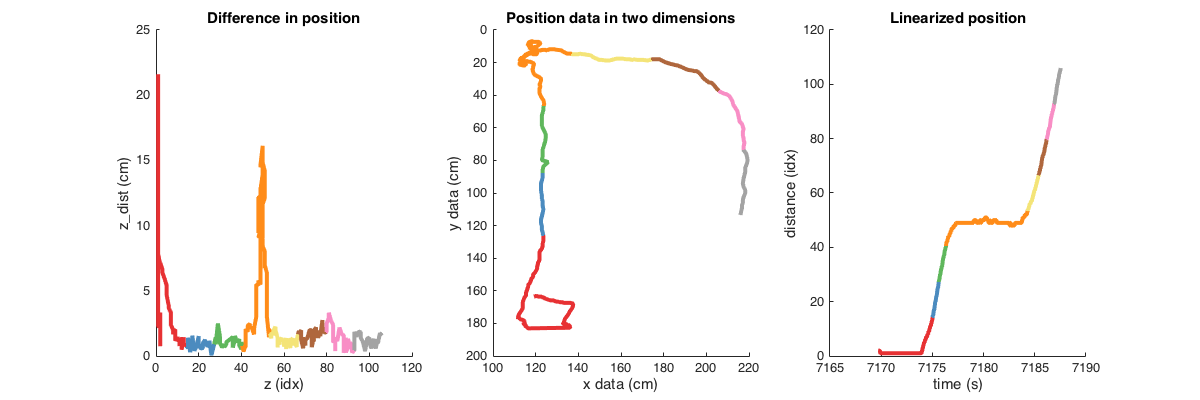

In [27]:
%plot -s 1200,400

figure;
subplot(131)
x = getd(lp_db,'z'); 
y = getd(lp_db,'z_dist'); 
z = zeros(size(x)); 
col = x;
surface([x;x],[y;y],[z;z],[col;col],'facecol','no','edgecol','interp','linew',3);
xlabel('z (idx)'); ylabel('z\_dist (cm)'); title('Difference in position');

subplot(132)
x = getd(pos2D,'x'); 
y = getd(pos2D,'y'); 
surface([x;x],[y;y],[z;z],[col;col],'facecol','no','edgecol','interp','linew',3);
set(gca,'YDir','reverse');
xlabel('x data (cm)'); ylabel('y data (cm)'); title('Position data in two dimensions');
set(gca,'YDir','reverse');

subplot(133)
x = lp2.tvec; 
y = lp2.data;
surface([x;x],[y;y],[z;z],[col;col],'facecol','no','edgecol','interp','linew',3);
xlabel('time (s)'); ylabel('distance (idx)'); title('Linearized position');

colormap(linspecer(8))

Take a look at the large spike at around 50 idx (left; orange region). This corresponds with the choice point region of the maze (center) where it appears that the rat meanders in a small area. This might occur when the animal is relatively stationary with respect to the overall trajectory (e.g., whisking at a choice point). Notice that it also corresponds to the the flat region of the linearized position (right). 

The way to think about this relationship is to imagine a flat line and a point. The point moving parallel to the line is equivalent to increases/decreases in linearized position or "`z`". The point moving perpendicular to the line is equivalent to increases/decreases in linearization error or "`z_dist`" (but no change in `z`!). 

#### This concludes the workflow tutorial!